In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import sys
sys.path.append('./code')
import get_mta_data as gmd
import process_mta_data as pmd

import datetime

# Loading and Preprocessing Data
First, let's load the data, clean up the column names, and add a datetime column, based on the entries in data and time

In [2]:
mta = gmd.load_local_data([2018], [4])

In [3]:
mta = pmd.clean_col_names(mta)

In [4]:
mta = pmd.add_datetime(mta)

In [5]:
mta = pmd.convert_date_to_datetime(mta)

Looks good so far!


## Inspecting the columns

Let's see what's in each column of the data.

In [6]:
mta.columns

Index(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'datetime'],
      dtype='object')

In [25]:
# mta.TIME.value_counts().tail(50000)
mta.DESC.value_counts()


REGULAR       786070
RECOVR AUD      2276
Name: DESC, dtype: int64

The mta website has a document with information on the various columns. Here's an excerpt from that file:
Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


C/A      = Control Area (A002)  
UNIT     = Remote Unit for a station (R051)  
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)  
STATION  = Represents the station name the device is located at  
LINENAME = Represents all train lines that can be boarded at this station  
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.  
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
DATE     = Represents the date (MM-DD-YY)  
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event  
DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)  
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.   
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.   
ENTRIES  = The comulative entry register value for a device  
EXIST    = The cumulative exit register value for a device  



Example:  
The data below shows the entry/exit register values for one turnstile at control area (A002) from 09/27/14 at 00:00 hours to 09/29/14 at 00:00 hours  


C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS  
A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,00:00:00,REGULAR,0004800073,0001629137,  
A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,04:00:00,REGULAR,0004800125,0001629149,  
A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,08:00:00,REGULAR,0004800146,0001629162,  

### Grouping by turnstyle
According to the challenge questions, a turnstyle is identified by: C/A, UNIT, SCP, and STATION.

Let's try grouping by these things

In [7]:
df = mta
df['turnstile_id'] = df['CA'] + df['UNIT'] + df['SCP'] # + df['STATION'] # station is redundant
groupby = df.groupby(['turnstile_id'])
groupby.agg({"ENTRIES": "mean"})

,ENTRIES
turnstile_id,
A002R05102-00-00,6.580823e+06
A002R05102-00-01,5.900872e+06
A002R05102-03-00,1.061938e+06
A002R05102-03-01,6.560952e+05
A002R05102-03-02,5.738634e+06
...,...
TRAM1R46800-00-02,1.749284e+06
TRAM2R46900-00-00,4.038833e+06
TRAM2R46900-00-01,2.559396e+06


The number 4717 is significant: It's the number of turnstiles in the subway system. According to google (how many subway stations in new york), there are 472 stations, so that's an average of 10 turnstiles per station, which seems reasonable.

## Plotting one turnstile
Let's plot the entries data for one arbitrarily selected turnstile.

In [8]:
df = mta
turnstile_0 = df[ (df['CA'] == 'A002') & (df['UNIT'] == 'R051') & (df['SCP'] == '02-00-00') & (df['STATION'] == '59 ST')]

In [9]:
turnstile_0 = turnstile_0.set_index(('datetime'))

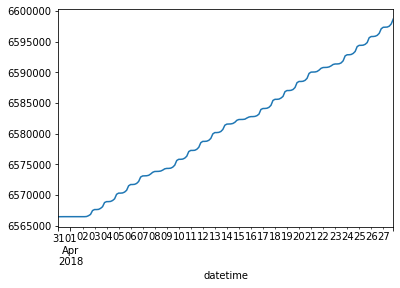

In [10]:
turnstile_0['ENTRIES'].plot()

## Plotting one turnstile with matplotlib (Challenge 4)
Let's do the same thing, only with matplotlib

(array([736785., 736789., 736793., 736797., 736801., 736805., 736809.,
        736813.]), <a list of 8 Text xticklabel objects>)

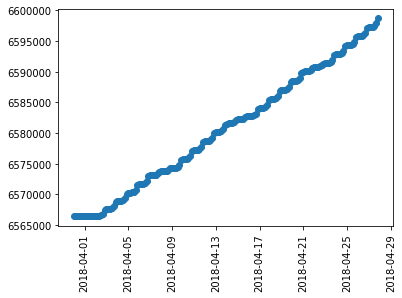

In [11]:
df = mta
turnstile_0 = df[ (df['CA'] == 'A002') & (df['UNIT'] == 'R051') & (df['SCP'] == '02-00-00') & (df['STATION'] == '59 ST')]
plt.plot_date(turnstile_0['datetime'],turnstile_0['ENTRIES'],xdate=True,ydate=False)
plt.xticks(rotation='vertical')

## Counts per ControlArea/UNIT/STATION per day (challenge 5)

In [12]:
# df = mta

# df = df.set_index('datetime')
# # get just the 0 hour ones
# df = pd.concat([df, pd.DataFrame(hours, index=df.index)], axis=1)
# df = df.rename(columns=({'datetime': 'hour'}))
# df [df['hour'] == 0]

# # for development, get just one C/A

In [13]:
groupby = df.groupby(['CA', 'UNIT', 'STATION'])
groupby.agg('mean')


,,,ENTRIES,EXITS
CA,UNIT,STATION,,
A002,R051,59 ST,4.882117e+06,2.342292e+06
A006,R079,5 AV/59 ST,6.228433e+06,6.183317e+06
A007,R079,5 AV/59 ST,2.223226e+07,2.217576e+06
A010,R080,57 ST-7 AV,1.024920e+07,3.161090e+06
A011,R080,57 ST-7 AV,6.881364e+08,5.101246e+08
...,...,...,...,...
S101,R070,ST. GEORGE,1.435320e+06,1.764078e+03
S101A,R070,ST. GEORGE,7.860426e+06,5.956389e+03
S102,R165,TOMPKINSVILLE,1.356321e+06,3.543631e+05


## ins and outs
Eli wrote a function to consider differences between adjacent records

In [14]:
df = mta.copy()
df = df.set_index('datetime')
mask = df.index.hour == 0
df = df[mask]

In [15]:
# df = df.sort_index()
# df_in = mta.copy()

df[df.turnstile_id == "A002R05102-00-00"]
df = pmd.add_ins_outs_to_df(df)

In [16]:
df[df.turnstile_id == "A002R05102-00-00"]

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,turnstile_id,INS,OUTS
datetime,,,,,,,,,,,,,,
2018-03-31,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-03-31,00:00:00,REGULAR,6566463,2224050,A002R05102-00-00,NaN,NaN
2018-04-01,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-01,00:00:00,REGULAR,6566470,2224055,A002R05102-00-00,7.0,5.0
2018-04-02,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-02,00:00:00,REGULAR,6566470,2224055,A002R05102-00-00,0.0,0.0
2018-04-03,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-03,00:00:00,REGULAR,6567630,2224496,A002R05102-00-00,1160.0,441.0
2018-04-04,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-04,00:00:00,REGULAR,6568921,2225039,A002R05102-00-00,1291.0,543.0
2018-04-05,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-05,00:00:00,REGULAR,6570307,2225512,A002R05102-00-00,1386.0,473.0
2018-04-06,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-06,00:00:00,REGULAR,6571707,2226010,A002R05102-00-00,1400.0,498.0
2018-04-07,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-07,00:00:00,REGULAR,6573108,2226461,A002R05102-00-00,6572582.0,2226461.0
2018-04-08,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-04-08,00:00:00,REGULAR,6573832,2226681,A002R05102-00-00,724.0,220.0
